In [1]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims, zeros, ones, asarray, savez_compressed, asarray, load
from numpy.random import randint, randn
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate
from matplotlib import pyplot
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [8]:
############# PREPROCESS DATA ###############

IMG_SIZE = 64

train_data_dir = 'C:\\_Thesis\VirtualEnv\\_datasets\\_archDataset\\_traindata'
CATEGORIES = ['-2600_-2000', '-550_-220', '1200_1600', '1600_1700', '1720_1840',
              '1800-1900', '1890_1935', '1895_1920', '1900_1940', '1919-1965', '1919-1965-2',
              '1920-1950', '1960_2000', '1980-2015', '600_800', '800_1200']

train_images = []       
train_labels = []

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))


def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

def create_training_data():
    counter = 1
    for category in CATEGORIES:
        path = os.path.join(train_data_dir, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                im = Image.open(os.path.join(path, img))
                im = im.convert('L')
                width, height = im.size
                if (width >=  (2 * height)) or  (height >=  (2 * width)):
                    print ("passed")
                    pass
                else:
                    im = crop_max_square(im)
                    im = im.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
                    im = img_to_array(im)
                    train_images.append(im)
                    train_labels.append(class_num)
                    counter += 1
                    print(counter, class_num)
            except Exception as e:
                print("err")
                pass

create_training_data()

train_labels = asarray(train_labels)
train_labels = train_labels.astype("float32")

filename = 'C:\\_Thesis\VirtualEnv\\_datasets\\_archDataset\\_traindata\\arc_64.npz'
savez_compressed(filename, train_images, train_labels)
print(train_images.shape)
print(train_labels.shape)


 15
3578 15
3579 15
3580 15
3581 15
3582 15
3583 15
3584 15
3585 15
3586 15
3587 15
3588 15
3589 15


AttributeError: 'list' object has no attribute 'shape'

Loaded:  (3588, 64, 64, 1) (3588,)


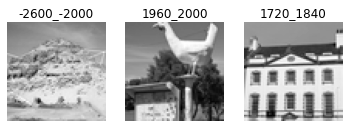

In [11]:
################### load dataset ################

data = load("C:\\_Thesis\VirtualEnv\\_datasets\\_archDataset\\_traindata\\arc_64.npz")
src_images, label = data["arr_0"], data["arr_1"]
print("Loaded: ", src_images.shape, label.shape)
#print source images
n_samples = 3
ix = randint(0, src_images.shape[0], n_samples)
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis("off")
    pyplot.imshow(src_images[ix[i]].astype("uint8"), cmap="gray")
    pyplot.title(CATEGORIES[int(label[ix[i]])])

pyplot.show()

In [6]:
############## TRAIIN FUNCS #################
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=16):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1] * 3
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 3))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample 32x32
    fe = Conv2D(64, (3,3), strides=(2,2), padding="same")(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    # downsample 16x16
    fe = Conv2D(64, (3,3), strides=(2,2), padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    # downsample 8x8
    fe = Conv2D(64, (3,3), strides=(2,2), padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    # downsample 4x4
    fe = Conv2D(64, (3,3), strides=(2,2), padding="same")(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # output
    out_layer = Dense(1, activation="sigmoid")(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=16):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 4 * 4 * 3
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((4, 4, 3))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 64 * 4 * 4 * 3
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 64 * 3))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 8x8
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, (4,4), activation="tanh", padding="same")(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

#load and prepare training images
def load_real_samples(filename):
    #load the compressed arrays
    data = load(filename)
    #unpack the arrays
    X1, X2 = data["arr_0"], data["arr_1"]
    #scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    return[X1, X2]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=16):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# create and save a plot of generated images
def save_plot(examples, epoch, label, n=3):
        # scale from [-1,1] to [0,1]
        examples = (examples + 1) / 2.0
        # plot images
        for i in range(n * n):
            # define subplot
            pyplot.subplot(n, n, 1 + i)
            # turn off axis
            pyplot.axis("off")
            # plot raw pixel data
            pyplot.imshow(examples[i], cmap="gray")
            pyplot.title(CATEGORIES[int(label[i])])
        # save plot to file
        filename = "C:\\_Thesis\\VirtualEnv\\__ganResults\\ARCHcGAN\\generated_plot_e%03d.png" % (epoch+1)
        pyplot.savefig(filename)
        pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=9):
        # prepare real samples
        [X_real, label_r], y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real examples
        _, acc_real = d_model.evaluate([X_real, label_r], y_real, verbose=0)
        # prepare fake examples
        [x_fake, label], y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        _, acc_fake = d_model.evaluate([x_fake, label], y_fake, verbose=0)
        # summarize discriminator performance
        print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
        # save plot
        save_plot(x_fake, epoch, label)
        # save the generator model tile file
        filename = "C:\\_Thesis\\VirtualEnv\\_models\\ARCHcGAN\\generator_model_%03d.h5" % (epoch+1)
        if (epoch + 1 ) % 4 == 0:
            g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate ✬fake✬ examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print(">%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f" %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        summarize_performance(i, g_model, d_model, dataset, latent_dim)
    # save the generator model
    g_model.save("C:\\_Thesis\\VirtualEnv\\_models\\_cGAN\\cgan_generator.h5")

In [7]:
############################### RUN TRAIN ####################################

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples("C:\\_Thesis\VirtualEnv\\_datasets\\_archDataset\\_traindata\\arc_64.npz")
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

611, d2=0.547 g=0.907
>35, 19/28, d1=0.602, d2=0.590 g=0.946
>35, 20/28, d1=0.614, d2=0.664 g=0.898


KeyboardInterrupt: 

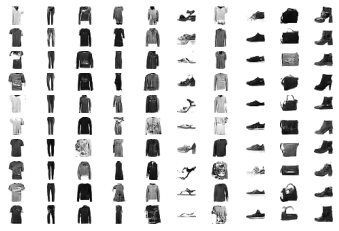

In [4]:
################################# Conditional Clothing Generation ############################

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
        pyplot.label()
    pyplot.show()

# load model
model = load_model("C:\\_Thesis\\VirtualEnv\\_models\\_cGAN\\cgan_generator.h5")
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)
